0.7.22
['SoftActivityJetHT2', 'FsrPhoton', 'GenJet', 'fixedGridRhoFastjetCentralCalo', 'GenIsolatedPhoton', 'Jet', 'LHEPdfWeight', 'GenMET', 'SoftActivityJetNjets10', 'SoftActivityJetNjets2', 'HLTriggerFinalPath', 'GenVisTau', 'ChsMET', 'RawPuppiMET', 'L1simulation', 'Photon', 'LHEPart', 'GenVtx', 'IsoTrack', 'genTtbarId', 'Muon', 'SoftActivityJetHT', 'Pileup', 'LHEScaleWeight', 'GenDressedLepton', 'luminosityBlock', 'L1', 'PV', 'Generator', 'GenPart', 'fixedGridRhoFastjetAll', 'DeepMETResolutionTune', 'SubJet', 'LHEReweightingWeight', 'LowPtElectron', 'Electron', 'Tau', 'LHE', 'PSWeight', 'SubGenJetAK8', 'fixedGridRhoFastjetCentralChargedPileUp', 'Flag', 'HLT', 'RawMET', 'TrigObj', 'run', 'GenJetAK8', 'fixedGridRhoFastjetCentralNeutral', 'HTXS', 'L1Reco', 'DeepMETResponseTune', 'genWeight', 'FatJet', 'MET', 'L1PreFiringWeight', 'btagWeight', 'HLTriggerFirstPath', 'SoftActivityJetHT10', 'SoftActivityJetNjets5', 'SV', 'SoftActivityJet', 'PuppiMET', 'boostedTau', 'fixedGridRhoFastjetCent

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa2af4c3100>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

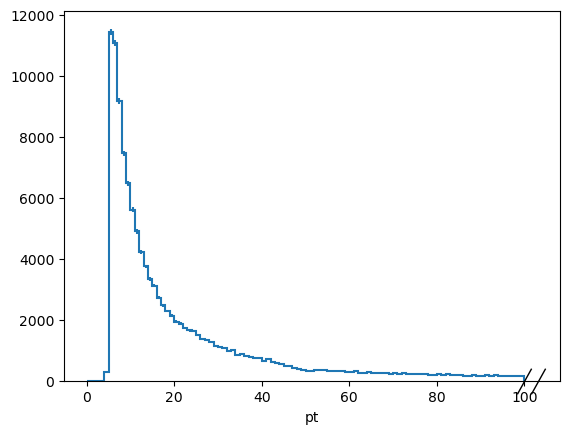

In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import pickle
import hist

print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from python.plugins import handleData
import lpcjobqueue
import sys
# redirector = 'root://xcache/'
# redirector='root://cmsxrootd.fnal.gov/' 
# redirector = 'root://xrootd.cmsaf.mit.edu:/'
redirector = 'root://cmsio2.rc.ufl.edu/'  #### florida
# redirector = 'root://osg-se.sprace.org.br/' #### Sao Paolo
# redirector = 'root://eos.cms.rcac.purdue.edu/' #### Purdue
# redirector ='root://dcache-cms-webdav-wan.desy.de/' ###DESY
# redirector = 'root://cmseos.fnal.gov/' ###T3 FNAL
# redirector='root://xrootd-local.unl.edu:1094/' ###Nebraska
# files = handleData('fileset_QCD.json', redirector, year = 2018, testing = True)
# files = handleData('datasets_UL_NANOAOD.json', redirector, year = 2018, testing = True)
file = redirector + '/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCH3_Flat_13TeV_herwig7/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v2/2830000/0211A5A2-3EE8-52\
4B-8D2D-F537D5C71EDC.root'
file = 'root://cmseos.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_HT500to700_TuneCH3_13TeV-madgraphMLM-herwig7/NANOAODSIM/106X_mc2017_realistic_v9-v1/60000/050C5B2E-727E-CD42-A392-F7DAAE9F8480.root'
events = NanoEventsFactory.from_root(file, 
                                     schemaclass=NanoAODSchema).events()
print(events.fields)
print(events.LHEWeight.originalXWGTUP)
h = hist.Hist.new.Regular(100, 0, 100, name="pt").Double()
h.fill(ak.flatten(events.Electron.pt))
h.plot1d()

# import uproot
# # ### uproot notation
# # qcd_mc = uproot.open(list(files.values())[-1][0])
# qcd_mc = uproot.open(redirector+"/store/data/Run2017D/JetHT/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/120000/4A70E050-A8B9-FA46-92C3-4A85F22FB255.root")
# uprootevents = qcd_mc['Events']
# print(uprootevents['FatJet_pt'].array())
# # for key in
# print(uprootevents["L1PreFiringWeight_Nom"].array())
# print(len(uprootevents_data["L1PreFiringWeight_Nom"].array()))

In [2]:
# # events=events[ak.all(events.FatJet[:,:2].jetId > 1, axis=-1)]
# print(ak.num(events.FatJet.jetId > 1) > 1)

# print("N events initial ", len(events))
# events_sel = events[ak.num(events.FatJet.jetId > 1) > 1]
# print(len(events_sel))

# print("Num jets pt greater than 200", ak.num(events_sel.FatJet.pt > 200))
# print(ak.all(events_sel.FatJet[:,:2].pt > 200., axis=-1))
# print(events_sel.FatJet[:,:2].pt)
# events_sel = events_sel[ak.all(events_sel.FatJet[:,:2].pt > 200., axis=-1)]
# print("Nevents with at least 2 jets ", len(events_sel))
# print(len(events_sel))
# print("N gen subjets per events ", ak.num(events_sel.SubGenJetAK8))
# print("N subjets per events ", ak.num(events_sel.SubJet))
# print("N jets per events ", ak.num(events_sel.FatJet))

# print("pt gen subjets ", events_sel.SubGenJetAK8.pt)
# print("pt subjets ", events_sel.SubJet.pt)
# print("pt fat jets ", events_sel.FatJet.pt)

# # h = hist.Hist.new.Regular(20, 0, 3, name="Fat Jet area").Double()
# # h.fill(ak.flatten(events.FatJet.area))
# # h.plot1d()


# print(events_sel.SubJet.pt)
# print("FatJet pt", events_sel.FatJet.pt)
# h2 = hist.Hist.new.Regular(200, 0, 2000, name="pt").Double()
# h2.fill(ak.flatten(events_sel.SubJet.pt))
# h2.plot1d()


# events = events[(ak.num(events.FatJet.msoftdrop) > 1) & ak.all(events.FatJet.msoftdrop > 0., axis=-1)]
# print("AK8 sd masses 0", events.FatJet.msoftdrop)
# print(events.FatJet.subJetIdx1[0])
# print(events.FatJet.subJetIdx2[0])
# print("Sdmasses for jet 1 ", (events.SubJet[0,events.FatJet.subJetIdx1[0,0]]+events.SubJet[0,events.FatJet.subJetIdx2[0,0]]).mass)
# print("Sdmasses for jet 2 ", (events.SubJet[0,events.FatJet.subJetIdx1[0,1]]+events.SubJet[0,events.FatJet.subJetIdx2[0,1]]).mass)
# newAK8mass = (events.SubJet[events.FatJet.subJetIdx1]+events.SubJet[events.FatJet.subJetIdx2]).mass
# SubJets = events.SubJet
# SubJets["area"] = SubJets.pt
# print(SubJets.area[events.FatJet.subJetIdx1])
# print((ak.local_index(SubJets.area)==events.FatJet.subJetIdx1[:,0]) | (ak.local_index(SubJets.area)==events.FatJet.subJetIdx2[:,0]))
# print(ak.local_index(SubJets.area)==events.FatJet.subJetIdx2[:,0])
# SubJets.area = ak.where((ak.local_index(SubJets.area)==events.FatJet.subJetIdx1[:,0]) | (ak.local_index(SubJets.area)==events.FatJet.subJetIdx2[:,0]), events.FatJet.area[:,0], SubJets.area)
# SubJets.area = ak.where((ak.local_index(SubJets.area)==events.FatJet.subJetIdx1[:,1]) | (ak.local_index(SubJets.area)==events.FatJet.subJetIdx2[:,1]), events.FatJet.area[:,1], SubJets.area)
# print(SubJets.area)
# print("Fat jet areas ", events.FatJet.area)

In [3]:
from python.plugins import *
from python.trijetProcessor import makeTrijetHists
from dask.distributed import Client


data = False
winterfell = False
casa = False
dask = True
testing= True
range = None
year="2018"
mctype = "MG"
jk=False
if jk:
    data = False
jk_range = [6,8]
if data:
    unc_srcs = ['nominal']
elif not data and mctype == 'herwig':
    unc_srcs = ['nominal']
else:
    unc_srcs = ['nominal', 'JERUp', 'JERDown', 'HEM',
 'JES_AbsoluteMPFBiasUp', 'JES_AbsoluteMPFBiasDown', 'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown', 
 'JES_AbsoluteStatUp', 'JES_AbsoluteStatDown', 'JES_FlavorQCDUp', 'JES_FlavorQCDDown', 'JES_FragmentationUp', 
 'JES_FragmentationDown', 'JES_PileUpDataMCUp', 'JES_PileUpDataMCDown', 'JES_PileUpPtBBUp', 'JES_PileUpPtBBDown', 
 'JES_PileUpPtEC1Up', 'JES_PileUpPtEC1Down', 'JES_PileUpPtEC2Up', 'JES_PileUpPtEC2Down', 'JES_PileUpPtHFUp', 'JES_PileUpPtHFDown', 
 'JES_PileUpPtRefUp', 'JES_PileUpPtRefDown', 'JES_RelativeFSRUp', 'JES_RelativeFSRDown', 'JES_RelativeJEREC1Up', 'JES_RelativeJEREC1Down',
 'JES_RelativeJEREC2Up', 'JES_RelativeJEREC2Down', 'JES_RelativeJERHFUp', 'JES_RelativeJERHFDown', 'JES_RelativePtBBUp', 'JES_RelativePtBBDown',
 'JES_RelativePtEC1Up', 'JES_RelativePtEC1Down', 'JES_RelativePtEC2Up', 
 'JES_RelativePtEC2Down', 'JES_RelativePtHFUp', 'JES_RelativePtHFDown', 'JES_RelativeBalUp', 
 'JES_RelativeBalDown', 'JES_RelativeSampleUp', 'JES_RelativeSampleDown', 'JES_RelativeStatECUp', 'JES_RelativeStatECDown',
 'JES_RelativeStatFSRUp', 'JES_RelativeStatFSRDown', 'JES_RelativeStatHFUp', 'JES_RelativeStatHFDown', 'JES_SinglePionECALUp', 'JES_SinglePionECALDown', 
 'JES_SinglePionHCALUp', 'JES_SinglePionHCALDown', 'JES_TimePtEtaUp', 'JES_TimePtEtaDown', 'JMRUp', 'JMRDown', 'JMSUp', 'JMSDown']
if jk:
    processor = makeTrijetHists(data = data, jet_systematics = unc_srcs, jk=jk, ycut=1.7, jk_range = jk_range)
    if jk_range != None:
        jkstring = "JK" + str(jk_range[0]) + str(jk_range[1]) + "_"
    else:
        jkstring = "JK" 
else: 
    jkstring = ""
    processor = makeTrijetHists(data = data, jet_systematics = unc_srcs, jk=jk, ycut=1.7)#, jk_range = jk_range)
datastring = "JetHT" if processor.do_gen == False else "QCDsim"
if year == 2016 or year == 2017 or year == 2018:
    year_str = str(year)
elif year == "2016" or year == "2016APV" or year == "2017" or year == "2018":
    year_str = year
else:
    year_str = "All"
datastring = "JetHT" if processor.do_gen == False else "QCDsim"
if processor.do_gen==True and winterfell:
    filename = "QCD_flat_files.json"
elif processor.do_gen==True:
    print("gen true")
    # filename = "fileset_QCD.json"
    if mctype == "MG":
        filename = "fileset_MG_pythia8_wRedirs.json"
    elif mctype == "herwig":
        # filename = "fileset_HERWIG_flat_wRedirs.json"
        filename = "fileset_HERWIG_wRedirs.json"
    elif mctype == "pythia":
        filename = "fileset_QCD_wRedirs.json"
else:
    # filename = "datasets_UL_NANOAOD.json"
    filename = "fileset_JetHT_wRedirs.json"
print(filename)
if testing and not data:
        fname = 'coffeaOutput/trijet/trijetHistsTest_newherwigxs_{}_rap{}_{}_{}{}.pkl'.format(datastring, processor.ycut, mctype, jkstring, year_str)
elif testing and data:
    fname = 'coffeaOutput/trijet/trijetHistsTest_newherwigxs_{}_rap{}_{}_{}{}.pkl'.format(datastring, processor.ycut,mctype, jkstring, year_str)
elif not testing and data:
    fname = 'coffeaOutput/trijet/trijetHists_newherwigxs_{}_rap{}_{}_{}{}.pkl'.format(datastring, processor.ycut,mctype, jkstring, year_str)
else:
    fname = 'coffeaOutput/trijet/trijetHists_newherwigxs_{}_rap{}_{}_{}{}.pkl'.format(datastring, processor.ycut,mctype, jkstring, year_str)
if range!=None:
    print("Range input: ", range)
    fname=fname[:-4]+"_"+str(range[0])+"_"+str(range[1])+".pkl"
    print("New ranged fname ", fname)

2.7.2
0.7.22
Data:  False  gen  True
gen true
fileset_MG_pythia8_wRedirs.json


In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
# %%capture cap
run_ind_srcs = False
if run_ind_srcs == True:
    for src in unc_srcs:
        print("Running for source ", src)
        processor = makeTrijetHists(data = data, jet_systematics = [src], ycut=1.7, jk=jk, jk_range=jk_range)
        result = runCoffeaJob(processor, jsonFile = filename, casa = casa, winterfell = winterfell, year = year, testing = testing, dask = dask, 
                              data = not processor.do_gen, datasetRange = range)
        if testing and not data:
            fname = 'coffeaOutput/trijet/trijetHistsTest_wXSscaling_{}_pt{}_rapidity{}_{}{}.pkl'.format(datastring, processor.ptcut, processor.ycut, src, year_str)
        elif testing and data:
            fname = 'coffeaOutput/trijet/trijetHistsTest{}_pt{}_rapidity{}_{}{}.pkl'.format(datastring, processor.ptcut, processor.ycut, src, year_str)
        elif not testing and data:
            fname = 'coffeaOutput/trijet/trijetHists_{}_pt{}_rapidity{}_{}{}.pkl'.format(datastring, processor.ptcut, processor.ycut, src, year_str)
        else:
            fname = 'coffeaOutput/trijet/trijetHists_wXSscaling_{}_pt{}rapidity{}_{}{}.pkl'.format(datastring, processor.ptcut, processor.ycut, src, year_str)
        if range!=None:
            print("Range input: ", range)
            fname=fname[:-4]+"_"+str(range[0])+"_"+str(range[1])+".pkl"
            print("New ranged fname ", fname)
        with open(fname, "wb") as f:
            pickle.dump( result, f)
else:
    result = runCoffeaJob(processor, jsonFile = filename, casa = casa, winterfell = winterfell, year = year,
                      testing = testing, dask = dask, data = not processor.do_gen, datasetRange = range)
with open(fname, "wb") as f:
    pickle.dump( result, f)
# with open('trijet_'+datastring+year_str+processor.btag+'output.txt', 'w') as f:
#     f.write(cap)

Running over datasets  dict_keys(['/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM', '/QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM', '/QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM', '/QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM', '/QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM', '/QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM', '/QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM'])
Running on LPC Condor
/proxy/8787/status
<Client:

2.7.2
0.7.22
Hist(
  StrCategory(['pythiaMG2018'], growth=True, name='dataset', label='Primary dataset'),
  StrCategory(['nominal', 'JERUp', 'JERDown', 'HEM', 'JES_AbsoluteMPFBiasUp', 'JES_AbsoluteMPFBiasDown', 'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown', 'JES_AbsoluteStatUp', 'JES_AbsoluteStatDown', 'JES_FlavorQCDUp', 'JES_FlavorQCDDown', 'JES_FragmentationUp', 'JES_FragmentationDown', 'JES_PileUpDataMCUp', 'JES_PileUpDataMCDown', 'JES_PileUpPtBBUp', 'JES_PileUpPtBBDown', 'JES_PileUpPtEC1Up', 'JES_PileUpPtEC1Down', 'JES_PileUpPtEC2Up', 'JES_PileUpPtEC2Down', 'JES_PileUpPtHFUp', 'JES_PileUpPtHFDown', 'JES_PileUpPtRefUp', 'JES_PileUpPtRefDown', 'JES_RelativeFSRUp', 'JES_RelativeFSRDown', 'JES_RelativeJEREC1Up', 'JES_RelativeJEREC1Down', 'JES_RelativeJEREC2Up', 'JES_RelativeJEREC2Down', 'JES_RelativeJERHFUp', 'JES_RelativeJERHFDown', 'JES_RelativePtBBUp', 'JES_RelativePtBBDown', 'JES_RelativePtEC1Up', 'JES_RelativePtEC1Down', 'JES_RelativePtEC2Up', 'JES_RelativePtEC2Down', 'JES_Relati

KeyError: 'jet_eta_phi'

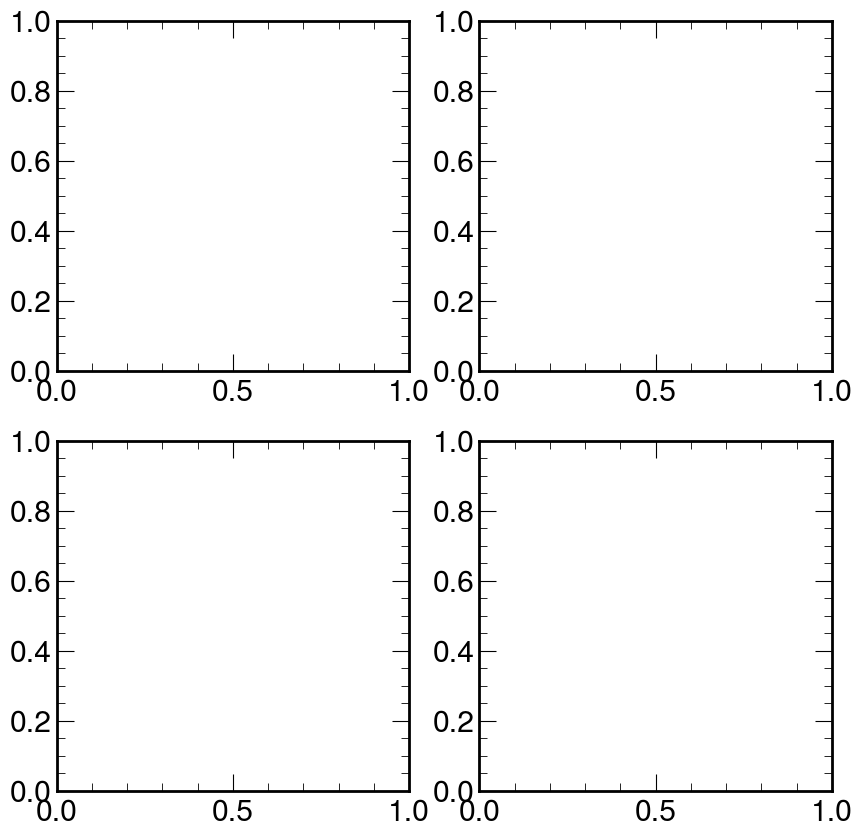

In [6]:
with open(fname, "rb") as f:
    result = pickle.load( f )
# result=result[0]
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10)
print(result['jet_eta_phi_precuts'])
df = pd.DataFrame.from_dict(result['cutflow'])
# display(df)
fig, axs = plt.subplots(2, 2)
result['jet_eta_phi'][{'syst':'nominal'}].project("eta", "phi").plot2d(ax=axs[0,0])
result['jet_eta_phi_preveto'][{'syst':'nominal'}].project("eta", "phi").plot2d(ax = axs[0,1])
result['jet_eta_phi_precuts'][{'syst':'nominal'}].project("eta", "phi").plot2d(ax = axs[1,0])
print(result['cutflow']['trigger_init'])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
print(result)
result['jet_eta_phi'][{'syst':'nominal'}].project("phi", "eta").plot2d()

if not data:
    fig, axs = plt.subplots(1, 3)
    result['dphimin_gen'].plot1d(ax = axs[0])
    result['asymm_gen'].plot1d(ax=axs[1], density=True)
    result['njet_gen'].plot1d(ax=axs[2], density=True)
    plt.legend()

fig, axs = plt.subplots(1, 3)
result['dphimin_reco'].plot1d(ax = axs[0])
result['asymm_reco'].plot1d(ax=axs[1])
result['njet_reco'].plot1d(ax=axs[2])
plt.legend()

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Ungroomed (top) and groomed (bottom) reco jets')
result['ptreco_mreco_u'][{'syst':"nominal"}].project('ptreco').plot1d(ax=axs[0,0], binwnorm=True)
result['ptreco_mreco_u'][{'syst':"nominal"}].project('mreco').plot1d(ax=axs[0,1], binwnorm=True)
result['ptreco_mreco_g'][{'syst':"nominal"}].project('ptreco').plot1d(ax=axs[1,0], binwnorm=True)
result['ptreco_mreco_g'][{'syst':"nominal"}].project('mreco').plot1d(ax=axs[1,1], binwnorm=True)
axs[0,0].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[0,1].set_yscale('log')
plt.savefig(os_path+"/test_pt_m_gen_u_g.png")

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Ungroomed (top) and groomed (bottom) reco jets')
result['misses'][{'syst':"nominal"}].project('ptgen').plot1d(ax=axs[0,0])
result['misses'][{'syst':"nominal"}].project('mgen').plot1d(ax=axs[0,1])
result['fakes'][{'syst':"nominal"}].project('ptreco').plot1d(ax=axs[1,0])
result['fakes'][{'syst':"nominal"}].project('mreco').plot1d(ax=axs[1,1])
axs[0,0].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[0,1].set_yscale('log')

### Plotting Response Matrices

In [ ]:
print([ax.name for ax in result['response_matrix_u'].axes])
data = False
if not data:
    response_matrix_u_values = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").values()
    response_matrix_g_values = result['response_matrix_g'].project("ptreco", "mreco", "ptgen", "mgen").values()
    print(result['response_matrix_u'][{"ptreco":1, "ptgen":2,"mreco":5, "mgen":10, "dataset":sum}])
    response_matrix_np_vals_u, ptreco_edges, mreco_edges, ptgen_edges, mgen_edges = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").to_numpy()
    result['response_matrix_u'][{"ptreco":0, "ptgen":0,"dataset":sum,"syst":"nominal"}].plot2d()
    plt.show()
    result['response_matrix_u'][{"ptreco":sum, "ptgen":sum,"dataset":sum, "syst":"nominal"}].plot2d()
    plt.show()
    nptreco,nmassreco,nptgen,nmassgen = response_matrix_u_values.shape
    print(response_matrix_u_values.shape)
    response_matrix_g_final = response_matrix_g_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )
    response_matrix_u_final = response_matrix_u_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) ) 
    print("Max ungroomed value np ", np.max(response_matrix_u_final))
    print("Location of max cal in 4d array :", np.argwhere(response_matrix_np_vals_u==49) )
    print(response_matrix_np_vals_u[0,9,0,4])
    print("Location of max cal in 2d array :", np.argwhere(response_matrix_u_final==49) )
    print(response_matrix_u_final[9,4])
    print("Location of max cal in 2d array :", np.argwhere(response_matrix_u_final.flatten()==49) )
    print(9*nmassgen*nptgen+4)
    print(response_matrix_u_final.flatten()[9*nmassgen*nptgen+4])
    ptreco_centers = (ptreco_edges[:-1]+ptreco_edges[1:])/2
    mreco_centers = (mreco_edges[:-1]+mreco_edges[1:])/2
    ptgen_centers = (ptgen_edges[:-1]+ptgen_edges[1:])/2
    mgen_centers = (mgen_edges[:-1]+mgen_edges[1:])/2
    response_matrix_bins = np.ones(np.append(response_matrix_u_values.shape,4))
    response_matrix_ptreco_bins = np.ones_like(response_matrix_u_values)
    print(response_matrix_ptreco_bins.ndim)
    response_matrix_mreco_bins = np.ones_like(response_matrix_u_values)
    response_matrix_ptgen_bins = np.ones_like(response_matrix_u_values)
    response_matrix_mgen_bins = np.ones_like(response_matrix_u_values)
    for ipt in np.arange(len(ptreco_centers)):
        for im in np.arange(len(mreco_centers)):
            for jpt in np.arange(len(ptgen_centers)):
                for jm in np.arange(len(mgen_centers)):
                    response_matrix_ptreco_bins[ipt,im,jpt,jm] = ptreco_centers[ipt]
                    response_matrix_mreco_bins[ipt][im][jpt][jm] = mreco_centers[im]
                    response_matrix_ptgen_bins[ipt][im][jpt][jm] = ptgen_centers[jpt]
                    response_matrix_mgen_bins[ipt][im][jpt][jm] = mgen_centers[jm]
                    response_matrix_bins[ipt][im][jpt][jm] = [ptreco_centers[ipt], mreco_centers[im], ptgen_centers[jpt], mgen_centers[jm]]
    response_matrix_ptreco_bins = response_matrix_ptreco_bins.reshape((nptreco)*(nmassreco), (nptgen)*(nmassgen))
    response_matrix_mgen_bins = response_matrix_mgen_bins.reshape((nptreco)*(nmassreco), (nptgen)*(nmassgen))
    response_matrix_bins = response_matrix_bins.reshape((nptreco)*(nmassreco), (nptgen)*(nmassgen), 4)
    print(response_matrix_bins[1][:10])
    print(response_matrix_ptreco_bins[1][:10])
    print(response_matrix_mgen_bins[1][:10])

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow( np.log(response_matrix_u_final+1), vmax=10, aspect="equal", cmap="Blues" )
plt.xlabel("GEN", fontsize=10)
plt.ylabel("RECO", fontsize=10)
plt.tick_params(labelsize=20)

In [ ]:
result['fakes'][{"dataset":sum, "syst":"nominal"}].plot2d()
plt.show()
result['misses'][{"dataset":sum, "syst":"nominal"}].plot2d()
plt.show()
result['misses'][{"dataset":sum, "syst":"nominal"}].plot2d()
plt.show()

In [ ]:
nbins_ptreco = len(result['response_matrix_u'].project("ptreco").values())
nbins_mreco = len(result['response_matrix_u'].project("mreco").values())
pt_reco_bins, pt_reco_edges = result['response_matrix_u'].project("ptreco").to_numpy()
pt_gen_bins, pt_gen_edges = result['response_matrix_u'].project("ptgen").to_numpy()
print("Pt reco bins and edges: ", pt_reco_bins, pt_reco_edges)
print("Pt gen bins and edges: ", pt_gen_bins, pt_gen_edges)
print(len(pt_gen_edges), nbins_ptreco)
m_reco_bins, m_reco_edges = result['response_matrix_u'].project("mreco").to_numpy()
m_gen_bins, m_gen_edges = result['response_matrix_u'].project("mgen").to_numpy()
print("M reco bins and edges: ", m_reco_bins, m_reco_edges)
print("M gen bins and edges: ", m_gen_bins, m_gen_edges)

In [ ]:
if not data:
    plt.figure(figsize = (40,80))
    plt.imshow( np.log(response_matrix_u_final+1), aspect="equal", cmap="Blues" )
    plt.xlabel("RECO", fontsize=50)
    plt.ylabel("GEN", fontsize=50)
    plt.tick_params(labelsize=40)

In [ ]:
if not data:
    plt.figure(figsize = (40,80))
    plt.imshow( np.log(response_matrix_g_final+1), aspect="equal", cmap="Blues" )
    plt.xlabel("RECO", fontsize=50)
    plt.ylabel("GEN", fontsize=50)
    plt.tick_params(labelsize=40)

In [ ]:
if not data:
    plt.figure(figsize = (40,80))
    plt.imshow( response_matrix_u_final, aspect="equal", cmap="Blues" )
    plt.xlabel("RECO", fontsize=50)
    plt.ylabel("GEN", fontsize=50)
    plt.tick_params(labelsize=40)

In [ ]:
print(result.keys())
print([ax.name for ax in result['alljet_ptreco_mreco'].axes])

plt.rcParams["figure.figsize"] = (20,20)
fig = plt.figure()
grid = fig.add_gridspec(2,2, figure=fig, wspace=0.1, hspace=0.1)
grid00 = grid[0,0].subgridspec(4,1, wspace=0, hspace=0)
grid01 = grid[0,1].subgridspec(4,1, wspace=0, hspace=0)
grid10 = grid[1,0].subgridspec(4,1, wspace=0, hspace=0)
grid11 = grid[1,1].subgridspec(4,1, wspace=0, hspace=0)
        
numerator = result['alljet_ptreco_mreco'][{'partonFlav':'Gluon'}].project('ptreco')
denominator = result['alljet_ptreco_mreco'].project('ptreco')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid00[:-1, :])
subplot_ax = fig.add_subplot(grid00[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)
plt.xlim(0,1600)
plt.xlabel("Pt all jets(GeV)")
plt.ylabel("Gluon fraction")

numerator = result['alljet_ptreco_mreco'][{'partonFlav':'Gluon', 'jetNumb':'jet3'}].project('ptreco')
denominator = result['alljet_ptreco_mreco'][{'jetNumb':'jet3'}].project('ptreco')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid01[:-1, :])
subplot_ax = fig.add_subplot(grid01[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)
plt.xlim(0,1600)
plt.xlabel("Pt for jet3 (GeV)")
plt.ylabel("Gluon fraction")
print("gluon purity per pt bin jet 3 ", numerator.values()/denominator.values())

numerator = result['alljet_ptreco_mreco'][{'partonFlav':'Gluon', 'jetNumb':'jet2'}].project('ptreco')
denominator = result['alljet_ptreco_mreco'][{'jetNumb':'jet2'}].project('ptreco')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid10[:-1, :])
subplot_ax = fig.add_subplot(grid10[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)
plt.xlim(0,1600)
plt.xlabel("Pt for jet2 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['alljet_ptreco_mreco'][{'partonFlav':'Gluon', 'jetNumb':'jet1'}].project('ptreco')
denominator = result['alljet_ptreco_mreco'][{'jetNumb':'jet1'}].project('ptreco')
print("gluon purity per pt bin ", numerator.values()/denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid11[:-1, :])
subplot_ax = fig.add_subplot(grid11[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)
plt.xlim(0,1600)
plt.xlabel("Pt for jet1 (GeV)")
plt.ylabel("Gluon fraction")
fig.suptitle('Gluon content as a function of pT')
plt.savefig(os_path + "gluonPtFrac.png")

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.gcf()
grid = fig.add_gridspec(2,2, figure=fig, wspace=0.1, hspace=0.1)
grid00 = grid[0,0].subgridspec(4,1, wspace=0, hspace=0)
grid01 = grid[0,1].subgridspec(4,1, wspace=0, hspace=0)
grid10 = grid[1,0].subgridspec(4,1, wspace=0, hspace=0)
grid11 = grid[1,1].subgridspec(4,1, wspace=0, hspace=0)

numerator = result['btag_eta'][{'partonFlav':'Gluon'}].project('eta')
denominator = result['btag_eta'].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid00[:-1, :])
subplot_ax = fig.add_subplot(grid00[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta all jets(GeV)")
plt.ylabel("Gluon fraction")

numerator = result['btag_eta'][{'partonFlav':'Gluon', 'jetNumb':'jet3'}].project('eta')
denominator = result['btag_eta'][{'jetNumb':'jet3'}].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid01[:-1, :])
subplot_ax = fig.add_subplot(grid01[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta for jet3 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['btag_eta'][{'partonFlav':'Gluon', 'jetNumb':'jet2'}].project('eta')
denominator = result['btag_eta'][{'jetNumb':'jet2'}].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid10[:-1, :])
subplot_ax = fig.add_subplot(grid10[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta for jet2 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['btag_eta'][{'partonFlav':'Gluon', 'jetNumb':'jet1'}].project('eta')
denominator = result['btag_eta'][{'jetNumb':'jet1'}].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid11[:-1, :])
subplot_ax = fig.add_subplot(grid11[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta for jet1 (GeV)")
plt.ylabel("Gluon fraction")
fig.suptitle('Gluon content as a function of eta')
plt.savefig(os_path+'/gluonEtaFrac' + ".png")

In [ ]:
#sum entries in bins --> plot as y-axis
plt.rcParams["figure.figsize"] = (20,5)
print([ax.name for ax in result['btag_eta'].axes])

fig, axs = plt.subplots(1, 3)
result['alljet_ptreco_mreco'][{'jetNumb':sum, 'ptreco':sum}].plot1d(ax = axs[0], overlay='partonFlav')
plt.rc('legend',fontsize='small')
plt.xlabel("Jet mass (GeV)")
result['alljet_ptreco_mreco'][{'jetNumb':sum,  'mreco':sum}].plot1d(ax = axs[1], overlay='partonFlav')
plt.rc('legend',fontsize='small')
#axs[0].set_xlabel("Jet mass (GeV)")
plt.xlabel("Jet pT (GeV)")
result['btag_eta'][{'jetNumb':sum, 'frac':sum}].plot1d(ax = axs[2], overlay='partonFlav')
plt.rc('legend',fontsize='small')
plt.legend()
plt.xlabel("Jet eta (GeV)")

print(axs)

fig.suptitle('Trijet parton content w/ med btag for all jets', fontsize="large")
plt.savefig(os_path+'/allJetPtEtaPhi_partons' + ".png")

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(3, 3)
result['alljet_ptreco_mreco'][{'jetNumb':'jet1', 'ptreco':sum}].plot1d(ax = axs[0,0], overlay='partonFlav', binwnorm=True)
plt.rc('legend',fontsize='small')
axs[0,0].set_xlabel("Jet1 mass (GeV)")
result['alljet_ptreco_mreco'][{'jetNumb':'jet1', 'mreco':sum}].plot1d(ax = axs[0,1], overlay='partonFlav', binwnorm=True)
axs[0,1].set_xlabel("Jet1 pT (GeV)")
result['btag_eta'][{'jetNumb':'jet1','frac':sum}].plot1d(ax = axs[0,2], overlay='partonFlav', binwnorm=True)
axs[0,2].set_xlabel("Jet1 eta (GeV)")
result['alljet_ptreco_mreco'][{'jetNumb':'jet2','ptreco':sum}].plot1d(ax = axs[1,0], overlay='partonFlav', binwnorm=True)
axs[1,0].set_xlabel("Jet2 mass (GeV)")
result['alljet_ptreco_mreco'][{'jetNumb':'jet2','mreco':sum}].plot1d(ax = axs[1,1], overlay='partonFlav', binwnorm=True)
axs[1,1].set_xlabel("Jet2 pT (GeV)")
result['btag_eta'][{'jetNumb':'jet2','frac':sum}].plot1d(ax = axs[1,2], overlay='partonFlav', binwnorm=True)
axs[1,2].set_xlabel("Jet2 eta (GeV)")
result['alljet_ptreco_mreco'][{'jetNumb':'jet3','ptreco':sum}].plot1d(ax = axs[2,0], overlay='partonFlav', binwnorm=True)
axs[2,0].set_xlabel("Jet3 mass (GeV)")
result['alljet_ptreco_mreco'][{'jetNumb':'jet3','mreco':sum}].plot1d(ax = axs[2,1], overlay='partonFlav', binwnorm=True)
axs[2,1].set_xlabel("Jet3 pT (GeV)")
result['btag_eta'][{'jetNumb':'jet3','frac':sum}].plot1d(ax = axs[2,2], overlay='partonFlav', binwnorm=True)
axs[2,2].set_xlabel("Jet3 eta (GeV)")
for ax in axs.flatten():
    ax.legend()
print(axs)
for i,ax in enumerate(axs.flatten()):
    if (i+1)%3!=0: 
        ax.set_yscale('log')
fig.suptitle('Trijet individual particle content bmed', fontsize="large")
plt.savefig(os_path+'/singleJetPtEtaPhi_partons' + ".png")

In [ ]:
# plt.rcParams["figure.figsize"] = (20,5)


# fig, axs = plt.subplots(1, 3)
print(result['alljet_ptreco_mreco'][{'jetNumb':sum, 'dataset':sum, 'ptreco':sum}])
result['alljet_ptreco_mreco'][{'dataset':sum, "partonFlav":sum, 'ptreco':sum}].plot1d(binwnorm=True, overlay='jetNumb')
plt.legend()
#axs[0].set_xlabel("Jet mass (GeV)")
plt.xlabel("Jet mass (GeV)")

In [ ]:
# plot mass after summing over partons

In [ ]:
fig, ax = plt.subplots(1, 1)
result['btag_eta'][{'jetNumb':'jet3', 'dataset':sum, 'eta':sum}].plot1d(overlay="partonFlav")
ax.set_xlabel("Jet3 b-tag disc.")
plt.legend()
#can do an anti b-tag --> inverse of recommendation

In [ ]:
njets=result['cutflow']['n3Jets']
ngluonjets=result['cutflow']['nGluonJets']
print(result['cutflow'])
print("Gluon purity:", ngluonjets/njets)

#plot pt, eta, phi, fake rate, pt efficiency, gluon purity for difference selections with b tags for all jets 
#and each individual jet in the 3 jets